In [1]:
%config InlineBackend.figure_format = 'retina' # For high-resolution.
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

import torch 
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.optim import Adam


import cv2
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings('ignore')

import segmentation_models_pytorch as smp
# from torchsampler import ImbalancedDatasetSampler


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

import gc

from efficientnet_pytorch import EfficientNet

In [2]:
# pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

In [2]:
## Hyperparameters
USERNAME = os.getcwd().split('/')[2]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
print(torch.cuda.device_count())

RESOLUTION = 512
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = True

LEARNING_RATE = 1e-4
NUM_EPOCHS = 20

THRESHOLD = 0.3
# MIN_ACTIVATION_SIZE = 

cuda
1


In [3]:
def read_df(df_type):
    #username = os.getcwd().split('/')[2]
    df_path = '/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_csv/{}.csv'.format(USERNAME, df_type)
    df = pd.read_csv(df_path)[['Mask_Path', 'XRay_Path', 'Intermediate_Predicted_Path']]
#     df = pd.read_csv(df_path)[['Mask_Path', 'XRay_Path']]
    df['Mask_Path'] = df['Mask_Path'].str.replace('anw008', USERNAME)
    df['XRay_Path'] = df['XRay_Path'].str.replace('anw008', USERNAME)
    df['Intermediate_Predicted_Path'] = df['Intermediate_Predicted_Path'].str.replace('anw008', USERNAME)
    df['SOP'] = df['XRay_Path'].apply(lambda x: x.split('/')[-1])
    
    df['No_Pneumothorax'] = df['Mask_Path'].str.contains('negative_mask').astype(int)
    df['Yes_Pneumothorax'] = 1 - df['No_Pneumothorax']
    
    
    return df

In [4]:
train_df = read_df('train')
val_df = read_df('validation')
test_df = read_df('test')
pos_df = read_df('train_pos')
neg_df = read_df('train_neg')

In [5]:
class CANDID_PTX(Dataset):
    def __init__(self, df, resolution, model_type):
        self.img_paths = df['XRay_Path'].values
        self.intermediate_paths = df['Intermediate_Predicted_Path'].values
        self.mask_paths = df['Mask_Path'].values
        self.labels = torch.tensor(df[['No_Pneumothorax', 'Yes_Pneumothorax']].values, dtype=torch.float32)
        # Just changed by Angela
        self.sop = df['SOP'].values
        self.resolution = resolution
        
        # model_type: 'C' for Classification, 'S' for Segmentation, 'E' for Ensemble
        self.model_type = model_type
              
        return
            
    
    def __len__(self):
        
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, idx):
        if self.model_type == 'E':
            # Designed for ensemble model's classification part
            label = self.labels[idx]
            
            new_img_path = self.intermediate_paths[idx]
            new_img = plt.imread(new_img_path)[:, :, :3]
            to_tensor = transforms.ToTensor()
            new_img = to_tensor(new_img)
            
            return new_img, label
        
        else:
            img_path = self.img_paths[idx]
            img = dicom.dcmread(img_path).pixel_array
            img_min = np.min(img)
            img_max = np.max(img)
            img_norm = (img - img_min) / (img_max - img_min)
            img_norm = cv2.resize(img_norm, (self.resolution, self.resolution))
            img_norm = torch.tensor(img_norm).expand(3, self.resolution, self.resolution)

            if self.model_type == 'C':
                # Designed for classification model
                label = self.labels[idx]

                return img_norm, label

            elif self.model_type == 'S':
                # Designed for segmentaion models (might change later)
                mask_path = self.mask_paths[idx]
                mask = plt.imread(mask_path)[:, :, 0]
                mask = cv2.resize(mask, (self.resolution, self.resolution))
    #             mask = np.where(mask < 0.5, 0, 1)
                mask = torch.tensor(mask).expand(1, self.resolution, self.resolution) 
        
                sop = self.sop[idx]

                return img_norm, mask, sop

In [6]:
def create_loaders(model_type):
    train_ds = CANDID_PTX(train_df, RESOLUTION, model_type)
    val_ds = CANDID_PTX(val_df, RESOLUTION, model_type)
    test_ds = CANDID_PTX(test_df, RESOLUTION, model_type)
    
    train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

    val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                              pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)

    test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                              pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)
    
    
    return train_loader, val_loader, test_loader

In [7]:
def create_train_loaders(schedule_type, cur_df=None, num_neg=0, model_type=None):
    if schedule_type == 3:
        cur_df = pd.concat([pos_df, neg_df.sample(n=num_neg, replace=False)]).sample(frac=1, ignore_index=True)
        
    train_ds = CANDID_PTX(cur_df, RESOLUTION, model_type)

    train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

    return train_loader, cur_df.shape[0]

In [8]:
def BCE_weight(num_pos, num_neg):
    return torch.tensor([1, num_neg / num_pos])

In [9]:
def plot_both_loss(all_train_loss, all_val_loss, model_type, model_name, model_schedule=None):
    plt.figure(figsize=(20, 10))
    sns.set(style="whitegrid")
    epoch_num = len(all_train_loss)
    df = pd.DataFrame({'x':np.arange(1, epoch_num+1),
                    'train_loss':all_train_loss,
                      'val_loss':all_val_loss})
    df = df.set_index('x')
    train_val_loss = sns.lineplot(data=df, linewidth=2.5)
#     train_val_loss.set_xticks(np.arange(1, epoch_num+1, 4), labels=np.arange(1, epoch_num+1, 4))
    # set the ticks first
    train_val_loss.set_xticks(np.arange(1, epoch_num+1, 1))

    # set the labels
    train_val_loss.set_xticklabels(np.arange(1, epoch_num+1, 1))


    ## now label the y- and x-axes.
    plt.ylabel('BCE Loss')
    plt.xlabel('Epoch Number')
    title = 'BCE Loss of {} model, {}'.format(model_type, model_name)
    plt.title(title)
    plt.show()
    
    fig = train_val_loss.get_figure()
    fig.savefig('metric_imgs/{}_type{}.png'.format(title, model_schedule), dpi=400)

In [10]:
def plot_confusion_matrix(y_test, y_true, model_type, model_name, model_schedule=None):
    
    cm = confusion_matrix(y_true, y_test)

    cm = sns.heatmap(cm, annot=True, cmap = 'Blues', fmt="d")
    title = 'Confusion matrix of {} model, {}'.format(model_type, model_name)
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()
    
    fig = cm.get_figure()
    fig.savefig('metric_imgs/{}_type{}.png'.format(title, model_schedule), dpi=400)

In [11]:
def plot_roc_curve(y_test, y_true, model_type, model_name, model_schedule=None):
    fpr, tpr, threshold = roc_curve(y_true, y_test, drop_intermediate = False)
    roc_auc = roc_auc_score(y_true, y_test)

    plt.figure(1)
    plt.plot([0, 1], [0, 1])
    roc_plt = plt.plot(fpr, tpr, label='{}(area = {:.3f})'.format(model_name, roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    title = 'ROC curve of {} model, {}'.format(model_type, model_name)
    plt.title(title)
    plt.legend(loc='best')
    plt.savefig('metric_imgs/{}_type{}.png'.format(title, model_schedule), dpi=400)
    
    plt.show()


In [12]:
def test_metrics(test_loader, model, model_type, model_name, model_schedule=None):
    """
    Calculate confusion matrix & auc-roc
    Return a list 
    """
    y_test = np.array([])
    y_true = np.array([])
    y_test_prob = np.array([])
    total_num_batch = 0
    for i, (imgs, labels) in enumerate(test_loader):
        total_num_batch += 1
        imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
        preds = model(imgs)
        
        soft_max = nn.Softmax(dim=1)
        pred_prob = soft_max(preds).detach().cpu().numpy()
        
        pred_label = np.argmax(pred_prob, axis=1)
        true_label = labels.detach().cpu().numpy().astype(int)[:, 1]
        
        y_test = np.concatenate((y_test, pred_label))
        y_true = np.concatenate((y_true, true_label))

        # add this line
        y_test_prob = np.concatenate((y_test_prob, pred_prob[:, 1]))
    
    
    plot_confusion_matrix(y_test, y_true, model_type, model_name, model_schedule)
    print("The F1-Score is: {}".format(f1_score(y_true, y_test)))
    print("The Recall (Sensitivity) is: {}".format(recall_score(y_true, y_test)))
    # modify this line, change from y_test to y_test_prob
    plot_roc_curve(y_test_prob, y_true, model_type, model_name, model_schedule)
    
    print('Total Number of Batch Size: ', total_num_batch)
    return y_test, y_true

In [13]:
def bi_mask(logit_mask, threshold):
    mask = np.where(logit_mask <= threshold, 0, 1)
    
    return mask

In [14]:
def calculate_dc(preds, true_mask):
    """
    Helper function to calculate dice coefficient from predicted and true masks, both in binary.
    """
    if np.sum(true_mask) == 0:
        # Return 0 if prediction is positive but true mask is negative
        if np.sum(preds) != 0:
            return 0
        else:
            # Return 1 if prediction and true mask are both negative
            return 1
    else:
        # Return 0 if prediction is negative but true mask is positive
        if np.sum(preds) == 0:
            return 0
        # Actually calculate dc if both prediction and mask are both positive
        dc = np.sum(preds[true_mask==1])*2.0 / (np.sum(preds) + np.sum(true_mask))
        return dc

In [15]:
def training_seg(model, num_epochs, batch_size, learning_rate, 
                    train_loader, val_loader, test_loader):
    """
    Main training function to train the first part of the ensemble model, which is the segmentation model.
    """
    
    model.to(DEVICE)
    
    all_train_loss = []
    all_val_loss = []
    all_preds = []
    all_masks = []
    all_xray = []
    val_dice = []
    all_dice = [] # Validation dice coefficient for the current validation set (one number per epoch, could see trend)
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    pos_total = pos_df.shape[0]
    neg_total = neg_df.shape[0]
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0
        batch_num = 0
                
        # If indicated number of epochs are not met, then keep optimizing the segmentation order.
        model.train()
        
        # Imbalanced dataset solution: (Strategy 2, resampling negative cases)
        if epoch % 4 == 0:
            cur_group = epoch // 4
            cur_df = pd.concat([pos_df, 
                        neg_df.iloc[int(cur_group * pos_total) : 
                                    int(np.minimum((cur_group + 1) * pos_total, neg_total))]]).sample(frac=1, 
                                                                                              ignore_index=True)
            train_loader, cur_num = create_train_loaders(2, cur_df, num_neg=0, model_type='S')
            print('current number of training set is: {}'.format(cur_num))

        for i, (imgs, masks, sops) in enumerate(train_loader):
            batch_num += 1
            imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
            optimizer.zero_grad()
            preds = model(imgs)

            # Print values to check dimensions of predicted images
            if (i == 0) & (epoch == 0):
                print(preds)
                print(preds.shape)
                print('cuda device_count: {}'.format(torch.cuda.device_count()))
            # Calculate loss and do back-propagation, then calculate total loss for this epoch
            loss = loss_fn(preds, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += float(loss.detach().cpu())

        all_train_loss.append(total_train_loss / batch_num)
        # Print the number of training batch
        if epoch == 0:
            print("Total # of training batch: ", i + 1)

    ## validation set
        batch_num = 0
        total_val_loss = 0
        model.eval()

        for i, (imgs, masks, sops) in enumerate(val_loader):
            batch_num += 1
            # Send imgs and masks to GPU so that they can be input to the model
            imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
            if (i == 0) & (epoch == 0):
                print(masks[0].unique())

            preds = model(imgs)
            loss = loss_fn(preds, masks) # is this mean or sum?
            total_val_loss += float(loss.detach().cpu()) # accumulate the total loss for this epoch.

            # Calculate validation set dice coefficient change over time 
            pred_bi = bi_mask(preds.detach().cpu().squeeze(), THRESHOLD)
            test_dice = []
            for batch_i in range(BATCH_SIZE):
                cur_dc = calculate_dc(pred_bi[batch_i], masks[batch_i].detach().cpu().squeeze().numpy())
                test_dice.append(cur_dc)
            val_dice.append(np.mean(test_dice))

            # Save the second validation loader set (4 samples) into a variable to be printed if we wish
            if i == 1:
                all_preds.append(preds.detach().cpu())
                all_masks.append(masks.detach().cpu())
                all_xray.append(imgs.detach().cpu())
        # Calculate the overall validation loss and dice-coefficient
        all_val_loss.append(total_val_loss / batch_num)
        all_dice.append(np.mean(val_dice))

        if epoch == 0:
            print("Total # of validation batch: ", i + 1)
        
    
    #plot_both_loss(all_train_loss, all_val_loss)
        
    return model, all_train_loss, all_val_loss, all_preds, all_masks, all_xray, all_dice

In [16]:
loaders_seg = create_loaders('S')

<hr>

## ResNet34 + U-Net (T 0.5, Min. 375)

In [ ]:
model_seg = smp.Unet("resnet34", encoder_weights="imagenet", in_channels = 3, classes=1, activation=None)

In [25]:
unet_model, train_loss, val_loss, logit_mask, true_mask, ori_xray, val_dice_arr = training_seg(model = model_seg,
                                            num_epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = None, 
                                            val_loader = loaders_seg[1], 
                                            test_loader = loaders_seg[2])


NameError: name 'model_seg' is not defined

In [ ]:
plot_both_loss(train_loss, val_loss, model_type='Classification', model_name='ResNet 34', model_schedule='2')

In [ ]:
y_test, y_true = test_metrics(test_loader=loaders_class[2], model=resnet_model, 
                              model_type='Classification', model_name='ResNet 34', model_schedule='2')

## ResNet34 + U-Net (T 0.3, Min. 375)

In [ ]:
model_seg = smp.Unet("resnet34", encoder_weights="imagenet", in_channels = 3, classes=1, activation=None)

## EfficientNet-B3 + U-Net (T 0.3, Min. 375)

In [17]:
def test_metrics_seg(test_loader, model, model_type, model_name, threshold, min_activation, model_schedule=None):
    """
    Calculate confusion matrix, No AUC-ROC for segmentation model, 
    Print Dice Coefficient on test set
    Return a list 
    """
    y_test = np.array([])
    y_true = np.array([])
    model.to(DEVICE)
    model.eval()
    test_dice = []

    total_num_batch = 0
    for i, (imgs, labels, sops) in tqdm(enumerate(test_loader)):
        total_num_batch += 1
        imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
        preds = model(imgs)
        preds_sigmoid = torch.sigmoid(preds[:, 0].squeeze())
        binarized = bi_mask(preds_sigmoid.detach().cpu().squeeze(), threshold)
        # Hard cutoff: prediction label is 1 if sum of all binary pixels > min_activation, otherwise prediction is 0. 
#         pred_label = [int(sum(map(sum, binarized_ind)).item() > min_activation) for binarized_ind in binarized]
        pred_label = np.array([np.sum(binarized_ind) > min_activation for binarized_ind in binarized]).astype(int)
        true_label = labels[:, 0].squeeze().detach().cpu().numpy()
        # True labels are 1 if sum of all pixels > 0, otherwith true label = 0
        true_label = np.array([np.sum(true_label_ind) > 0 for true_label_ind in true_label])
#         true_label = [int(sum(map(sum, true_label_ind[0])) > 0) for true_label_ind in true_label]
        y_test = np.concatenate((y_test, pred_label))
        y_true = np.concatenate((y_true, true_label))
        # Calculate Dice Coefficient (Disclaimer: NOT PERFECT, since the true masks are not binary)             
        batch_dice = []
        for batch_i in range(BATCH_SIZE):
            cur_dc = calculate_dc(binarized[batch_i], labels[batch_i].detach().cpu().squeeze().numpy())
            batch_dice.append(cur_dc)
        test_dice.append(np.mean(batch_dice))
    # Plot confusion matrix for the segmentation model
    plot_confusion_matrix(y_test, y_true, model_type, model_name, model_schedule)
    print("Threshold for this segmentation model: ", threshold)
    print("Minimum Activation Size: ", min_activation)
    
    print("The F1-Score is: {}".format(f1_score(y_true, y_test)))
    print("The Recall (Sensitivity) is: {}".format(recall_score(y_true, y_test)))
                     
    print("The Mean Test Dice Coefficient is {}".format(np.mean(test_dice)))
    
    print('Total Number of Batch Size: ', total_num_batch)
    return y_test, y_true 

In [18]:
model_seg_2 = smp.Unet("efficientnet-b3", encoder_weights="imagenet", in_channels = 3, classes=1, activation=None)

In [19]:
unet_model, train_loss, val_loss, logit_mask, true_mask, ori_xray, val_dice_arr = training_seg(model = model_seg_2,
                                            num_epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = None, 
                                            val_loader = loaders_seg[1], 
                                            test_loader = loaders_seg[2])


  0%|          | 0/20 [00:00<?, ?it/s]

current number of training set is: 5112
tensor([[[[-8.5642e-01, -3.5441e-02, -8.8631e-01,  ..., -7.4208e-01,
           -4.9678e-01,  4.1260e-02],
          [-5.3314e-01,  4.3151e-03, -1.2853e-01,  ..., -2.3623e+00,
           -8.3577e-01,  5.5057e-01],
          [-7.3615e-01, -8.9657e-01,  3.7640e-01,  ..., -1.6728e+00,
           -1.0003e+00, -3.5990e-01],
          ...,
          [-5.5047e-01,  1.5150e-02, -7.4048e-01,  ..., -3.9132e-01,
           -1.0300e+00, -2.5402e-01],
          [-6.3635e-01,  1.9768e-01, -2.6811e-01,  ..., -6.6506e-01,
           -5.1011e-01, -1.6525e-01],
          [-3.0779e-01,  8.4307e-02, -8.5322e-01,  ..., -3.2609e-01,
           -2.9755e-01, -1.0304e+00]]],


        [[[-8.5773e-01, -3.2572e-02, -8.4714e-01,  ..., -7.2302e-01,
           -4.7162e-01,  1.1958e-01],
          [-5.2912e-01,  1.2252e-02, -9.1536e-02,  ..., -2.3888e+00,
           -8.1762e-01,  5.2866e-01],
          [-7.4539e-01, -8.7833e-01,  4.8530e-01,  ..., -1.7865e+00,
           -1.00

## Load in models from here!

In [17]:
# # Save segmentation model!!!!
#cur_model = 'UNet_EfficientNet-B3_ep20_bs4_lr-4'
#torch.save(unet_model.state_dict(), '/home/{}/teams/dsc-180a---a14-[88137]/Angela_Cecilia_Saved_Models/{}_{}.pth'.format(USERNAME, cur_model, RESOLUTION))
# Load saved segmentation model
cur_model = 'UNet_EfficientNet-B3_ep20_bs4_lr-4'
path = '/home/{}/teams/dsc-180a---a14-[88137]/Angela_Cecilia_Saved_Models/{}_{}.pth'.format(USERNAME, cur_model, RESOLUTION)
model_seg_2_reload = smp.Unet("efficientnet-b3", encoder_weights="imagenet", in_channels = 3, classes=1, activation=None)
model_seg_2_reload.load_state_dict(torch.load(path))
model_seg_2_reload.eval()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /tmp/xdg-cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

0it [00:00, ?it/s]

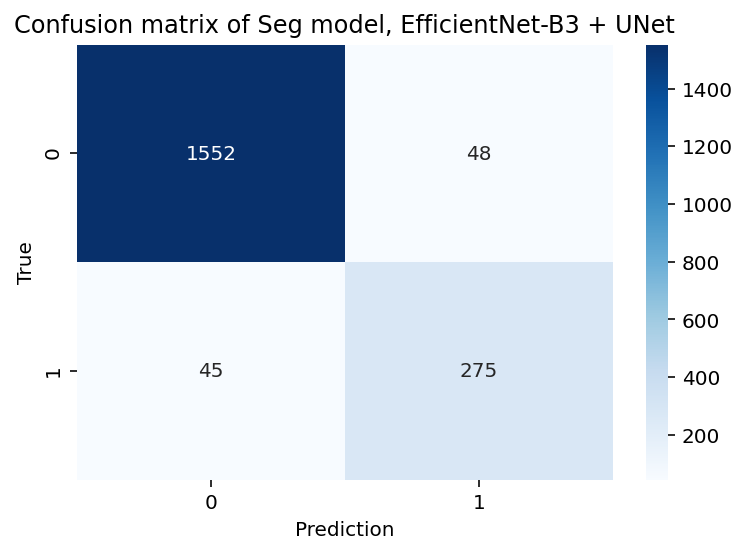

Threshold for this segmentation model:  0.3
Minimum Activation Size:  375
The F1-Score is: 0.8553654743390358
The Recall (Sensitivity) is: 0.859375
The Mean Test Dice Coefficient is 0.870125699477942
Total Number of Batch Size:  480


In [22]:
y_test, y_true = test_metrics_seg(test_loader=loaders_seg[2], model=model_seg_2_reload, 
                              model_type='Seg', model_name='EfficientNet-B3 + UNet', 
                                  model_schedule='2', threshold = 0.3, min_activation = 375)

## EfficientNet-B3 + FPN (T 0.5, Min. 375)


0it [00:00, ?it/s]

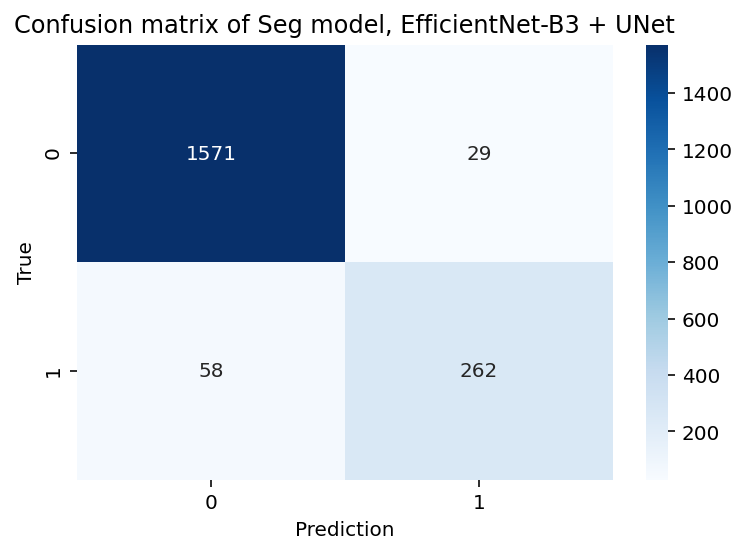

Threshold for this segmentation model:  0.5
Minimum Activation Size:  375
The F1-Score is: 0.8576104746317513
The Recall (Sensitivity) is: 0.81875
The Mean Test Dice Coefficient is 0.8973686706659041
Total Number of Batch Size:  480


In [19]:
y_test, y_true = test_metrics_seg(test_loader=loaders_seg[2], model=model_seg_2_reload, 
                              model_type='Seg', model_name='EfficientNet-B3 + UNet', 
                                  model_schedule='2', threshold = 0.5, min_activation = 375)

## Save the predicted images from segmentation

In [18]:
def save_images_predicted_by_static_model(model, data_loader, BATCH_SIZE):
    """
    Helper function to help the training process less repetitive. Take in trained, static model (assumed to be moved to GPU already),
    and save the predicted images from each separate data_loader.
    """
    for i, (imgs, masks, sops) in tqdm(enumerate(data_loader)):
        # Get predicted masks from current model
        imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
        preds = model(imgs)

        # Save the first channel as the original image (Format: [4 x 3 x 256 x 256])
        # The 3 channels are exactly the same due to gray scale
        new_img = imgs.detach().cpu().numpy()
        # Change the last channel to predicted mask
        new_img[:, 2] = preds.detach().cpu().squeeze()

        for k in range(BATCH_SIZE):
        # Deal with the dimensionality issue and the normalization for the predicted mask channel, then save
            cur_img = new_img[k]
            cur_img = np.swapaxes(cur_img.transpose(), 0, 1)
            out_min = np.min(cur_img[:, :, 2])
            out_max = np.max(cur_img[:, :, 2])
            out_norm = (cur_img[:, :, 2] - out_min) / (out_max - out_min)
            cur_img[:, :, 2] = out_norm
            # Save
            plt.imsave('/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_PREDS/{}_predicted.png'.format(USERNAME, sops[k]), cur_img)
    return

In [19]:
all_neg_loader = create_train_loaders(3, num_neg=neg_df.shape[0], model_type='S')

In [20]:
def save_imgs_based_on_model(model, loaders_seg, all_neg_loader, loader_type):
    """
    Main function to actually save all the predicted images
    """
    model.eval()
    model.to(DEVICE)
    if loader_type == "train":
        save_images_predicted_by_static_model(model, all_neg_loader, BATCH_SIZE)
        print("Saved all the predicted masks for training!")
    elif loader_type == 'validation':
        save_images_predicted_by_static_model(model, loaders_seg[1], BATCH_SIZE)
        print("Saved all the predicted masks for validation!")
    else:
        save_images_predicted_by_static_model(model, loaders_seg[2], BATCH_SIZE)
        print("Saved all the predicted masks for test!")
    return

In [21]:
save_imgs_based_on_model(model_seg_2_reload, loaders_seg, all_neg_loader[0], loader_type = "train")

0it [00:00, ?it/s]

Saved all the predicted masks for training!


In [24]:
all_SOP = []
for i, (imgs, masks, sops) in tqdm(enumerate(all_neg_loader[0])):
    all_SOP.append(sops)

0it [00:00, ?it/s]

In [29]:
flatten_sop = np.array(all_SOP).flatten()
flatten_sop.shape

(15396,)

In [31]:
combine_df = pd.concat([pos_df, neg_df])
lucky_df = combine_df[~combine_df['SOP'].isin(flatten_sop)]

In [33]:
lucky_ds = CANDID_PTX(lucky_df, RESOLUTION, 'S')
    
lucky_loader = DataLoader(lucky_ds, batch_size = 1, num_workers = NUM_WORKERS, 
                      pin_memory = PIN_MEMORY, drop_last = False, shuffle = True)

In [34]:
save_images_predicted_by_static_model(model_seg_2_reload, lucky_loader, 1)

0it [00:00, ?it/s]

lucky bastard is
- '7.5.10.361148.24.3.2.4.91848698957.3432309679762.9'

In [39]:
save_imgs_based_on_model(model_seg_2_reload, loaders_seg, all_neg_loader[0], loader_type = "validation")

0it [00:00, ?it/s]

Saved all the predicted masks for validation!


In [40]:
save_imgs_based_on_model(model_seg_2_reload, loaders_seg, all_neg_loader[0], loader_type = "test")

0it [00:00, ?it/s]

Saved all the predicted masks for test!
